In [67]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.polynomial.legendre import leggauss
from hmf import MassFunction
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

h = 0.7
H0 = h * 100  # km/s/Mpc
sigma8 = 0.8
Om0 = 0.318

area_deg2 = 10000.0

Mmin = 10 ** 13.5  # Msun
Mmax = 1e15  # Msun
Mmin_h = Mmin / h
Mmax_h = Mmax / h

zmin = 0.3
zmax = 0.8


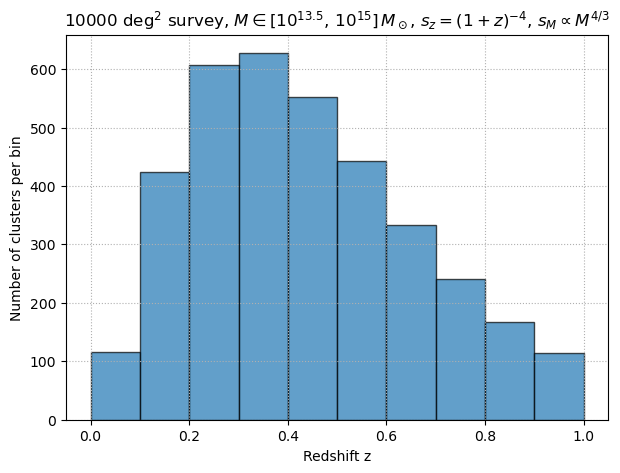

In [68]:
mf = MassFunction(
    z=0.3,
    cosmo_params={"H0": H0, "Om0": Om0},
    sigma_8=sigma8,
    Mmin=np.log10(Mmin/h), Mmax=np.log10(Mmax/h),
    hmf_model="Tinker08",
    transfer_model="EH"
    #mdef=mdef,                 # <-- only works if your version supports it
)
M = mf.m
dM = np.gradient(M)

def volume_shell(zmin, zmax, Om0, area_deg2):
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
    V = (cosmo.comoving_volume(zmax) - cosmo.comoving_volume(zmin)).to(u.Mpc**3).value
    V /= h**3
    f_sky = area_deg2 / 41253.0
    return V * f_sky

# for mass bin 5e12 to 2e15 and redshift bin 0.03 to 1.32


nM = 10
M_edges_logh = np.linspace(np.log10(Mmin/h), np.log10(Mmax/h), nM+1)
M_centres_logh = 0.5*(M_edges_logh[:-1] + M_edges_logh[1:])

# Mass scaling: lowest mass -> 0.1, highest -> 0.9
mass_scale = np.linspace(0.01, 1, nM)

# New redshift binning
z_edges = np.linspace(0.0, 1.0, 11)  # 10 bins from 0 to 1
z_centres = 0.5 * (z_edges[:-1] + z_edges[1:])
Nz = len(z_edges) - 1

def redshift_scale(z):
    """Return scaling factor depending on z using (1+z)^-4 dimming."""
    return (1.0 / (1.0 + z)**4)

N_counts = []

for zmin, zmax in zip(z_edges[:-1], z_edges[1:]):
    z_mid = 0.5*(zmin+zmax)
    V = volume_shell(zmin, zmax, Om0, area_deg2)

    N_counts_mass = 0.0
    for logMmin, logMmax in zip(M_edges_logh[:-1], M_edges_logh[1:]):
        # fix mass bin + redshift on HMF
        mf.update(Mmin=logMmin, Mmax=logMmax, z=z_mid)

        # per-bin midpoint mass in Msun/h for scaling
        Mmid_h = 10**(0.5*(logMmin + logMmax))       # Msun/h
        M_ref_h = 1e15 / h                            # Msun/h
        sM = min(1.0, (Mmid_h / M_ref_h)**(4.0/3.0))  # mass scaling

        # integrate dn/dM over this mass bin
        Mgrid = mf.m  # Msun/h
        if Mgrid.size < 2:
            # rare ultra-narrow fallback: rectangle rule with bin width in Msun/h
            dM_bin = (10**logMmax - 10**logMmin)
            n_z = mf.dndm[0] * dM_bin
        else:
            dM = np.gradient(Mgrid)
            n_z = np.einsum('i,i->', mf.dndm, dM, dtype=float)  # h^3 Mpc^-3

        N_counts_mass += n_z * V * sM

    N_counts.append(N_counts_mass * redshift_scale(z_mid) * 900/5000)

# --- plot
plt.figure(figsize=(7,5))
plt.bar(
    z_edges[:-1],
    N_counts,
    width=np.diff(z_edges),  # linear Δz width
    align="edge", edgecolor="k", alpha=0.7
)
plt.xlabel("Redshift z")
plt.ylabel("Number of clusters per bin")
plt.title(fr"{area_deg2:.0f} deg$^2$ survey, $M\in[10^{{13.5}},\,10^{{15}}]\,M_\odot$, $s_z=(1+z)^{{-4}}$, $s_M\propto M^{{4/3}}$")
plt.grid(True, ls=":")
plt.show()

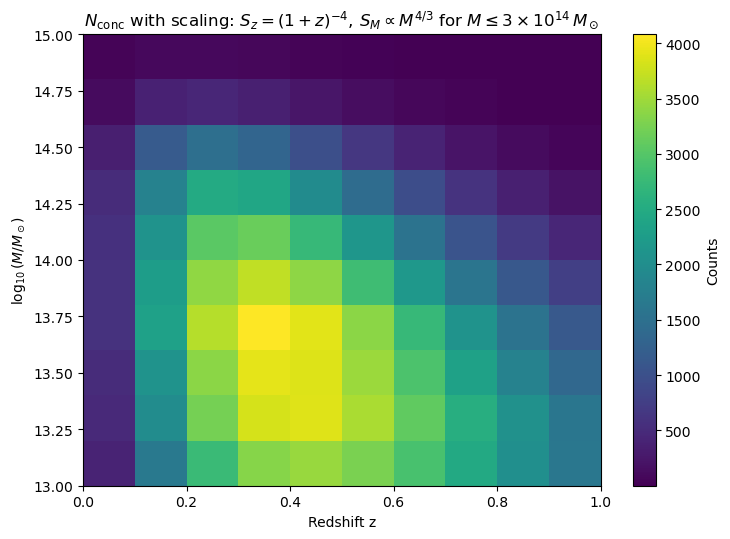

In [69]:
#Plot 1: gridCC

def mass_scale(M):
    # Normalise so that S_M(1e15) = 1
    return (M / 3e14)**(4/3)

# Binning
nM = 10
M_edges = np.logspace(13.0, 15.0, nM+1)   # Msun
z_edges = np.linspace(0.0, 1.0, 11)       # 10 bins
Nz, nM = len(z_edges)-1, len(M_edges)-1

# 2D counts
N_counts = np.zeros((nM, Nz))

for iz, (zmin, zmax) in enumerate(zip(z_edges[:-1], z_edges[1:])):
    z_mid = 0.5*(zmin+zmax)
    Vz = volume_shell(zmin, zmax, Om0, area_deg2)
    for im, (Mlo, Mhi) in enumerate(zip(M_edges[:-1], M_edges[1:])):
        mf.update(Mmin=np.log10(Mlo/h), Mmax=np.log10(Mhi/h), z=z_mid)
        dM = np.gradient(mf.m)
        n_z = np.sum(mf.dndm * dM)   # [h^3/Mpc^3]
        M_mid = (0.5*(Mlo + Mhi))  # Msun/h
        if M_mid >= 3e14:
             # Apply scaling
            N_counts[im, iz] = n_z * Vz * redshift_scale(z_mid)
        else:
            N_counts[im, iz] = n_z * Vz * redshift_scale(z_mid) * mass_scale(M_mid)

# Plot
plt.figure(figsize=(7.5, 5.5))
pcm = plt.pcolormesh(z_edges, np.log10(M_edges), N_counts, shading="auto")
plt.ylabel(r"$\log_{10}(M/M_\odot)$")
plt.xlabel("Redshift z")
plt.title(r"$N_{\rm conc}$ with scaling: $S_z=(1+z)^{-4},\,S_M\propto M^{4/3}$ for $M\leq 3\times 10^{14}\,M_\odot$")
#plt.title(r"Scaled counts per $(z,M)$ bin: $S_z=(1+z)^{-4},\,S_M\propto M^{4/3}$ for $M\leq 3\times 10^{14}\,M_\odot$")
plt.colorbar(pcm, label="Counts")
plt.tight_layout()
plt.show()

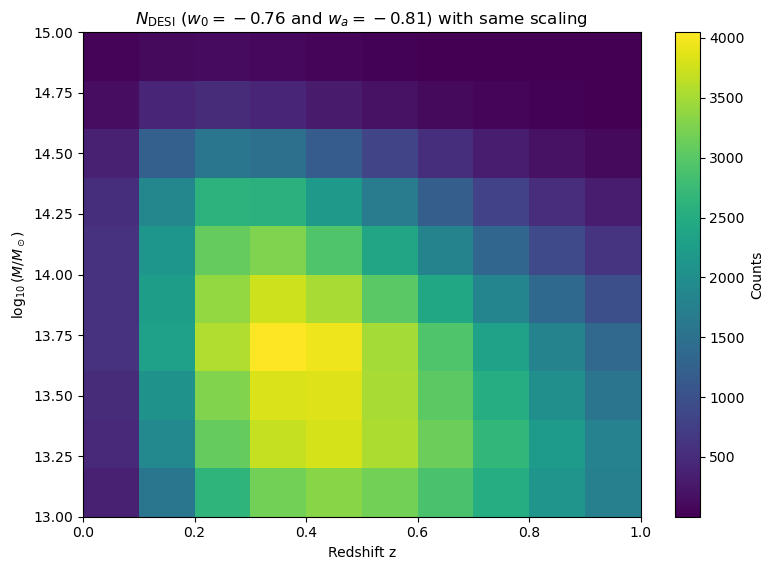

In [70]:
#Plot 2: gridDESI

from astropy.cosmology import Flatw0waCDM
# ---------- cosmologies ----------
#cosmo_conc = FlatwCDM(H0=H0, Om0=Om0, w0=-1.0)
cosmo_desi = Flatw0waCDM(H0=H0, Om0=Om0, w0=-0.76, wa = -0.81 , Ob0=0.049, Tcmb0=2.7255*u.K)
mf_desi = MassFunction(cosmo_model=cosmo_desi, hmf_model="Tinker08", transfer_model="EH")

# --- take your existing ΛCDM grid as "concordance"
#N_conc = np.array(N_counts, copy=True)   # shape (nM, Nz)

def volume_shell_cosmo(cosmo, zmin, zmax, area_deg2):
    V = (cosmo.comoving_volume(zmax) - cosmo.comoving_volume(zmin)).to(u.Mpc**3).value
    f_sky = area_deg2 / 41253.0
    return V * f_sky / h**3

# 2D counts
N_desi = np.zeros((nM, Nz))
for iz, (zmin, zmax) in enumerate(zip(z_edges[:-1], z_edges[1:])):
    z_mid = 0.5*(zmin+zmax)
    Vz = volume_shell_cosmo(cosmo_desi, zmin, zmax, area_deg2)
    for im, (Mlo, Mhi) in enumerate(zip(M_edges[:-1], M_edges[1:])):
        mf_desi.update(Mmin=np.log10(Mlo/h), Mmax=np.log10(Mhi/h), z=z_mid)
        dM = np.gradient(mf_desi.m)
        n_z = np.sum(mf_desi.dndm * dM)   # [h^3/Mpc^3]
        # Apply scaling
        M_mid = (0.5*(Mlo + Mhi))  # Msun/h
        if M_mid >= 3e14:
             # Apply scaling
            N_desi[im, iz] = n_z * Vz * redshift_scale(z_mid)
        else:
            N_desi[im, iz] = n_z * Vz * redshift_scale(z_mid) * mass_scale(M_mid)
            
# --- apply your global 900/5000 scaling to BOTH before comparing
#k = 900.0/5000.0
#N_conc_scaled = N_conc * k
#N_desi_scaled = N_desi * k
#S = np.sqrt((N_desi_scaled - N_conc_scaled)**2) / np.sqrt(N_conc_scaled)

# --- plot S grid (x=z, y=log10 M)
plt.figure(figsize=(8, 5.8))
pcm = plt.pcolormesh(z_edges, np.log10(M_edges), N_desi, shading="auto")
plt.xlabel("Redshift z")
plt.ylabel(r"$\log_{10}(M/M_\odot)$")
plt.title(r"$N_{\rm DESI}$ ($w_0=-0.76$ and $w_a = -0.81$) with same scaling")
#cbar.set_label("σ (Poisson-like)")
plt.colorbar(pcm, label="Counts")
plt.tight_layout()
plt.show()

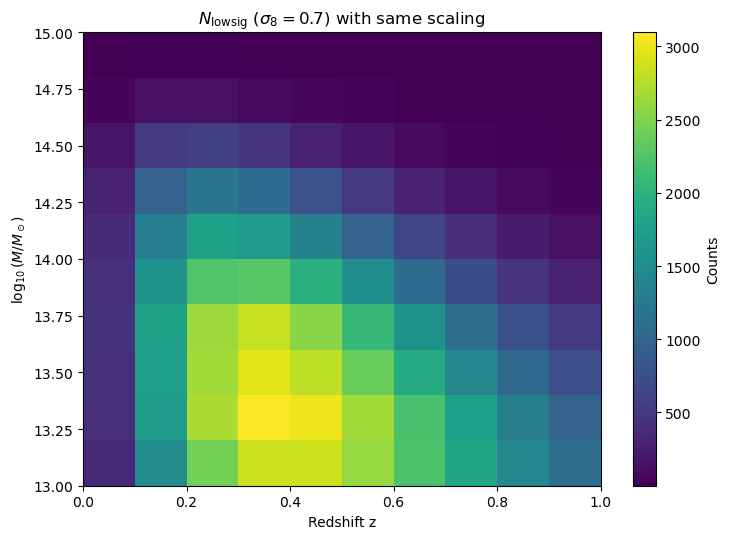

In [71]:
#Plot 3: gridlowsig

sigma8 = 0.7

cosmo_lowsig = FlatLambdaCDM(H0=H0, Om0=Om0, Ob0=0.049, Tcmb0=2.7255 * u.K, Neff=3.046)

mf_lowsig = MassFunction(
    cosmo_model=cosmo_lowsig,
    hmf_model="Tinker08",
    transfer_model="EH",
    sigma_8=sigma8,
)

# 2D counts
N_lowsig = np.zeros((nM, Nz))

for iz, (zmin, zmax) in enumerate(zip(z_edges[:-1], z_edges[1:])):
    z_mid = 0.5*(zmin+zmax)
    Vz = volume_shell_cosmo(cosmo_lowsig, zmin, zmax, area_deg2)
    for im, (Mlo, Mhi) in enumerate(zip(M_edges[:-1], M_edges[1:])):
        mf_lowsig.update(Mmin=np.log10(Mlo/h), Mmax=np.log10(Mhi/h), z=z_mid)
        dM = np.gradient(mf_lowsig.m)
        n_z = np.sum(mf_lowsig.dndm * dM)   # [h^3/Mpc^3]
        M_mid = (0.5*(Mlo + Mhi))  # Msun/h
        if M_mid >= 3e14:
             # Apply scaling
            N_lowsig[im, iz] = n_z * Vz * redshift_scale(z_mid)
        else:
            N_lowsig[im, iz] = n_z * Vz * redshift_scale(z_mid) * mass_scale(M_mid)

# Plot
plt.figure(figsize=(7.5, 5.5))
pcm = plt.pcolormesh(z_edges, np.log10(M_edges), N_lowsig, shading="auto")
plt.ylabel(r"$\log_{10}(M/M_\odot)$")
plt.xlabel("Redshift z")
plt.title(r"$N_{\rm lowsig}$ ($\sigma_8 = 0.7$) with same scaling")
#plt.title(r"Scaled counts per $(z,M)$ bin: $S_z=(1+z)^{-4},\,S_M\propto M^{4/3}$ for $M\leq 3\times 10^{14}\,M_\odot$")
plt.colorbar(pcm, label="Counts")
plt.tight_layout()
plt.show()

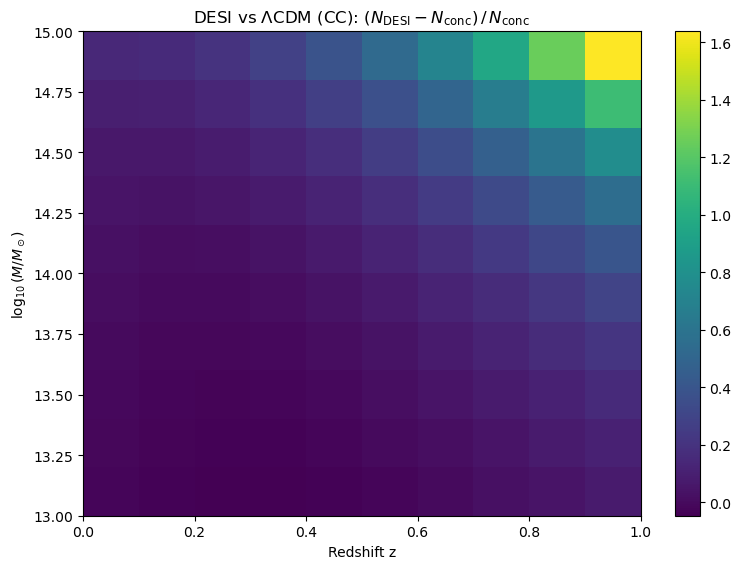

In [76]:
#Plot 4: [ grid-DESI - gridCC / grid CC ]

N_conc = np.array(N_counts, copy=True)   # shape (nM, Nz)
N_desi = np.array(N_desi, copy=True)   # shape (nM, Nz)

S = (N_desi - N_conc) / (N_conc)

# --- plot S grid (x=z, y=log10 M)
plt.figure(figsize=(8, 5.8))
pcm = plt.pcolormesh(z_edges, np.log10(M_edges), S, shading="auto")
plt.xlabel("Redshift z")
plt.ylabel(r"$\log_{10}(M/M_\odot)$")
plt.title(r"DESI vs ΛCDM (CC): ($N_{\rm DESI}-N_{\rm conc})\,/\,N_{\rm conc}$")
cbar = plt.colorbar(pcm)
#cbar.set_label("σ (Poisson-like)")
plt.tight_layout()
plt.show()

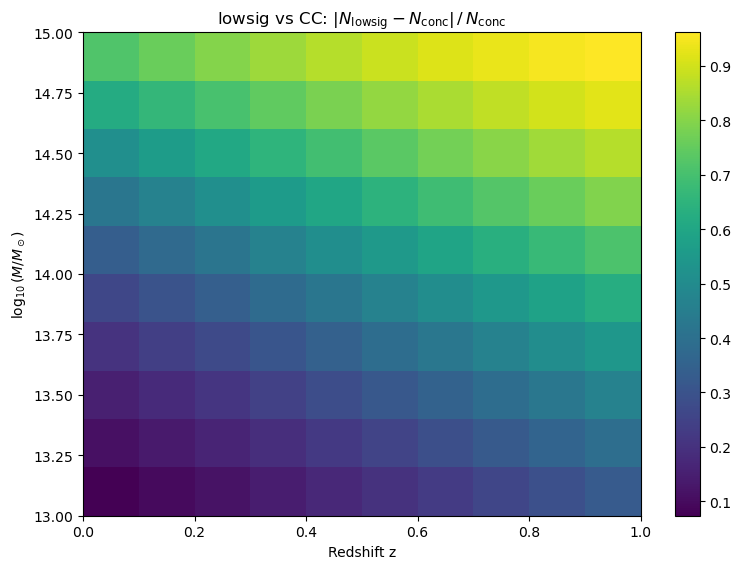

In [73]:
#Plot 5: [ grid-lowsig - gridCC / grid CC ]

N_lowsig = np.array(N_lowsig, copy=True)   # shape (nM, Nz)

S = np.abs(N_lowsig - N_conc) / (N_conc)

# --- plot S grid (x=z, y=log10 M)
plt.figure(figsize=(8, 5.8))
pcm = plt.pcolormesh(z_edges, np.log10(M_edges), S, shading="auto")
plt.xlabel("Redshift z")
plt.ylabel(r"$\log_{10}(M/M_\odot)$")
plt.title(r"lowsig vs CC: |$N_{\rm lowsig}-N_{\rm conc}|\,/\,N_{\rm conc}$")
cbar = plt.colorbar(pcm)
#cbar.set_label("σ (Poisson-like)")
plt.tight_layout()
plt.show()

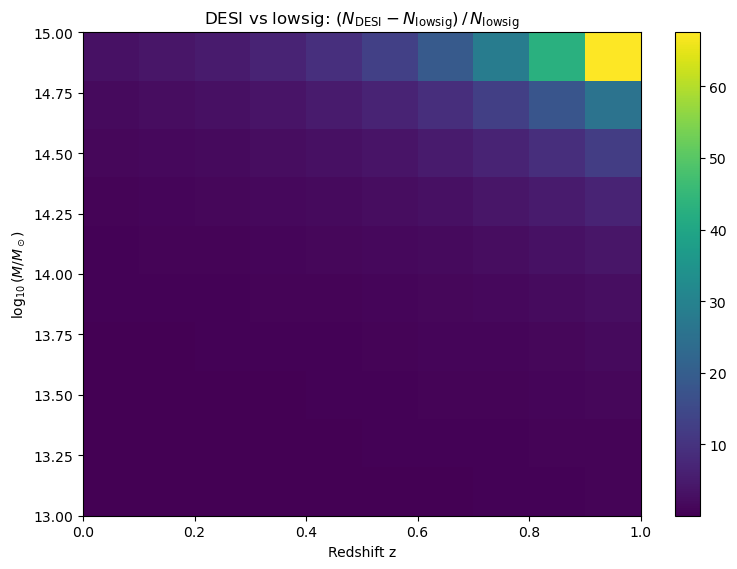

In [77]:
#Plot 5.1: [ grid-DESI - grid-lowsig / grid-lowsig ]

N_lowsig = np.array(N_lowsig, copy=True)   # shape (nM, Nz)

S = (N_desi - N_lowsig) / (N_lowsig)

# --- plot S grid (x=z, y=log10 M)
plt.figure(figsize=(8, 5.8))
pcm = plt.pcolormesh(z_edges, np.log10(M_edges), S, shading="auto")
plt.xlabel("Redshift z")
plt.ylabel(r"$\log_{10}(M/M_\odot)$")
plt.title(r"DESI vs lowsig: ($N_{\rm DESI}-N_{\rm lowsig})\,/\,N_{\rm lowsig}$")
cbar = plt.colorbar(pcm)
#cbar.set_label("σ (Poisson-like)")
plt.tight_layout()
plt.show()

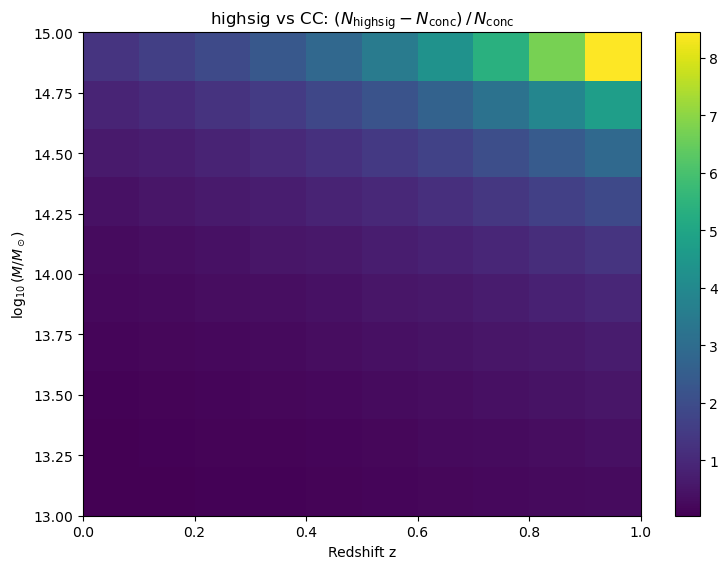

In [75]:
#Plot 5.2: [ grid-highsig - gridCC / grid CC ]

sigma8 = 0.9

cosmo_highsig = FlatLambdaCDM(H0=H0, Om0=Om0, Ob0=0.049, Tcmb0=2.7255 * u.K, Neff=3.046)

mf_highsig = MassFunction(
    cosmo_model=cosmo_highsig,
    hmf_model="Tinker08",
    transfer_model="EH",
    sigma_8=sigma8,
)

# 2D counts
N_highsig = np.zeros((nM, Nz))

for iz, (zmin, zmax) in enumerate(zip(z_edges[:-1], z_edges[1:])):
    z_mid = 0.5*(zmin+zmax)
    Vz = volume_shell_cosmo(cosmo_highsig, zmin, zmax, area_deg2)
    for im, (Mlo, Mhi) in enumerate(zip(M_edges[:-1], M_edges[1:])):
        mf_highsig.update(Mmin=np.log10(Mlo/h), Mmax=np.log10(Mhi/h), z=z_mid)
        dM = np.gradient(mf_highsig.m)
        n_z = np.sum(mf_highsig.dndm * dM)   # [h^3/Mpc^3]
        M_mid = (0.5*(Mlo + Mhi))  # Msun/h
        if M_mid >= 3e14:
             # Apply scaling
            N_highsig[im, iz] = n_z * Vz * redshift_scale(z_mid)
        else:
            N_highsig[im, iz] = n_z * Vz * redshift_scale(z_mid) * mass_scale(M_mid)

N_highsig = np.array(N_highsig, copy=True)   # shape (nM, Nz)

S = (N_highsig - N_conc) / (N_conc)

# --- plot S grid (x=z, y=log10 M)
plt.figure(figsize=(8, 5.8))
pcm = plt.pcolormesh(z_edges, np.log10(M_edges), S, shading="auto")
plt.xlabel("Redshift z")
plt.ylabel(r"$\log_{10}(M/M_\odot)$")
plt.title(r"highsig vs CC: ($N_{\rm highsig}-N_{\rm conc})\,/\,N_{\rm conc}$")
cbar = plt.colorbar(pcm)
#cbar.set_label("σ (Poisson-like)")
plt.tight_layout()
plt.show()

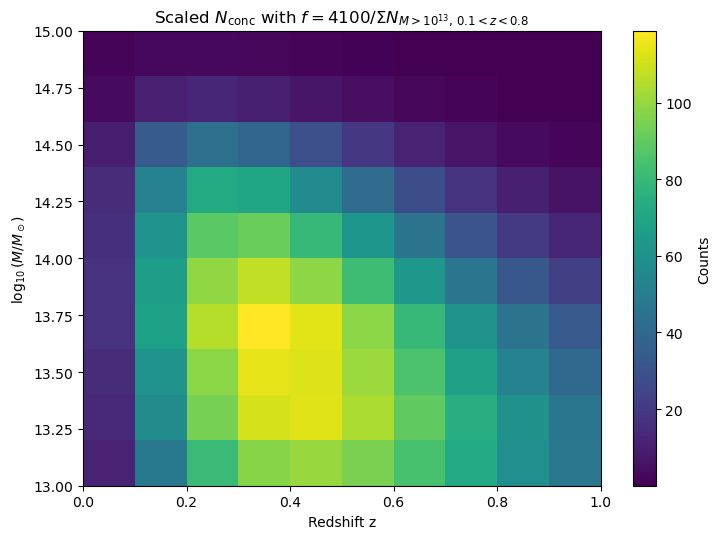

In [78]:
#Plot 6: rescale gridCC by 4100 / (sum of all bins with M>1e13 and 0.1<z<0.8)

# mask for bins with M > 1e13 and 0.1 < z < 0.8
M_mid = 0.5 * (M_edges[:-1] + M_edges[1:])
z_mid = 0.5 * (z_edges[:-1] + z_edges[1:])

# make a 2D mesh of mids
M_grid, Z_grid = np.meshgrid(M_mid, z_mid, indexing="ij")

mask = (M_grid > 1e13) & (Z_grid > 0.1) & (Z_grid < 0.8)

S = np.sum(N_counts[mask])
f = 4100.0 / S
N_counts_scaled = N_counts * f

# --- plot scaled gridCC
plt.figure(figsize=(7.5, 5.5))
pcm = plt.pcolormesh(z_edges, np.log10(M_edges), N_counts_scaled, shading="auto")
plt.ylabel(r"$\log_{10}(M/M_\odot)$")
plt.xlabel("Redshift z")
plt.title(r"Scaled $N_{\rm conc}$ with $f=4100/\Sigma N_{M>10^{13},\,0.1<z<0.8}$")
plt.colorbar(pcm, label="Counts")
plt.tight_layout()
plt.show()

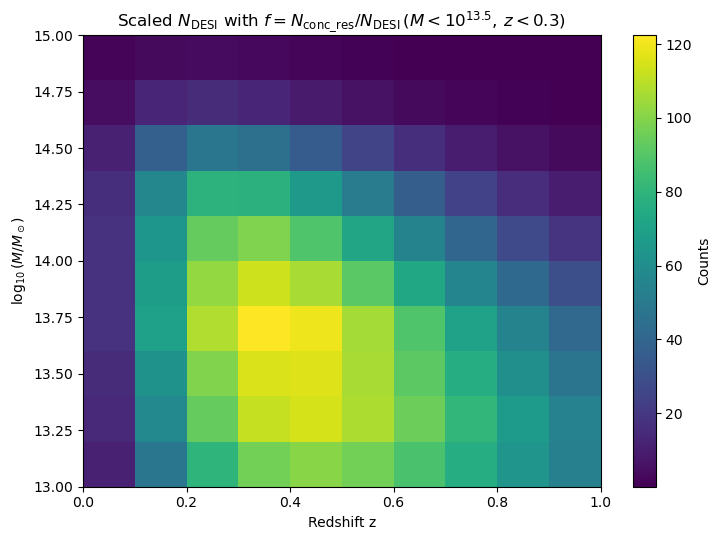

In [81]:
#Plot 7: recale gridDESI

mask = (M_grid < 10**13.5) & (Z_grid < 0.3)

S_rcc = np.sum(N_counts_scaled[mask])
S_desi = np.sum(N_desi[mask])
f = S_rcc / S_desi
N_counts_scaled_desi = N_desi * f

# --- plot scaled gridDESI
plt.figure(figsize=(7.5, 5.5))
pcm = plt.pcolormesh(z_edges, np.log10(M_edges), N_counts_scaled_desi, shading="auto")
plt.ylabel(r"$\log_{10}(M/M_\odot)$")
plt.xlabel("Redshift z")
plt.title(r"Scaled $N_{\rm DESI}$ with $f=N_{\rm conc\_re}/N_{\rm DESI}\, (M<10^{13.5},\,z<0.3)$")
plt.colorbar(pcm, label="Counts")
plt.tight_layout()
plt.show()

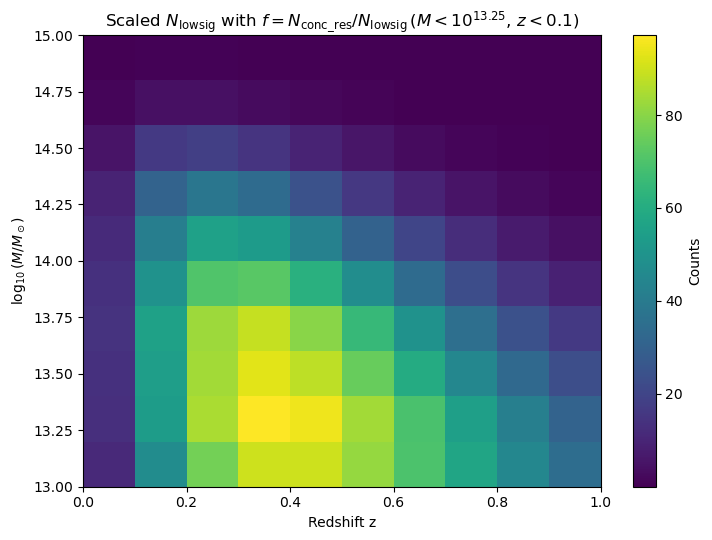

In [83]:
#Plot 8: recale grid-lowsig

mask = (M_grid < 10**13.25) & (Z_grid < 0.1)

S_rcc = np.sum(N_counts_scaled[mask])
S_lowsig = np.sum(N_lowsig[mask])
f = S_rcc / S_lowsig
N_counts_scaled_low = N_lowsig * f

# --- plot scaled gridDESI
plt.figure(figsize=(7.5, 5.5))
pcm = plt.pcolormesh(z_edges, np.log10(M_edges), N_counts_scaled_low, shading="auto")
plt.ylabel(r"$\log_{10}(M/M_\odot)$")
plt.xlabel("Redshift z")
plt.title(r"Scaled $N_{\rm lowsig}$ with $f=N_{\rm conc\_re}/N_{\rm lowsig}\, (M<10^{13.25},\,z<0.1)$")
plt.colorbar(pcm, label="Counts")
plt.tight_layout()
plt.show()

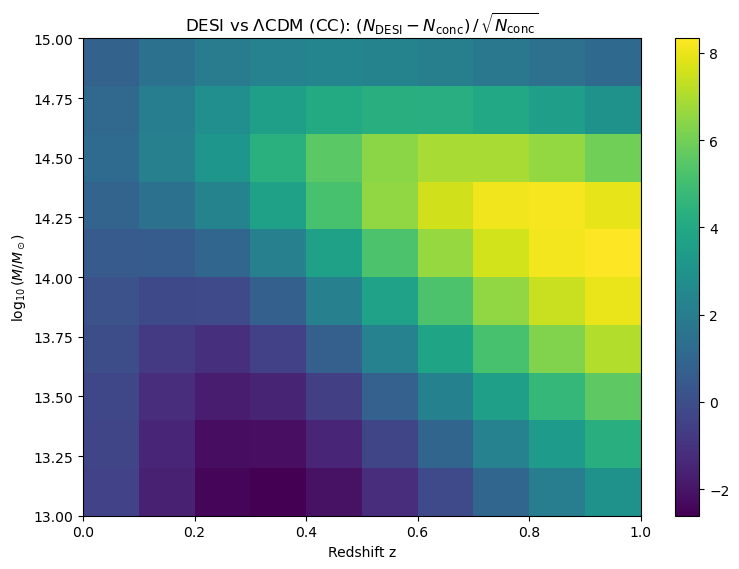

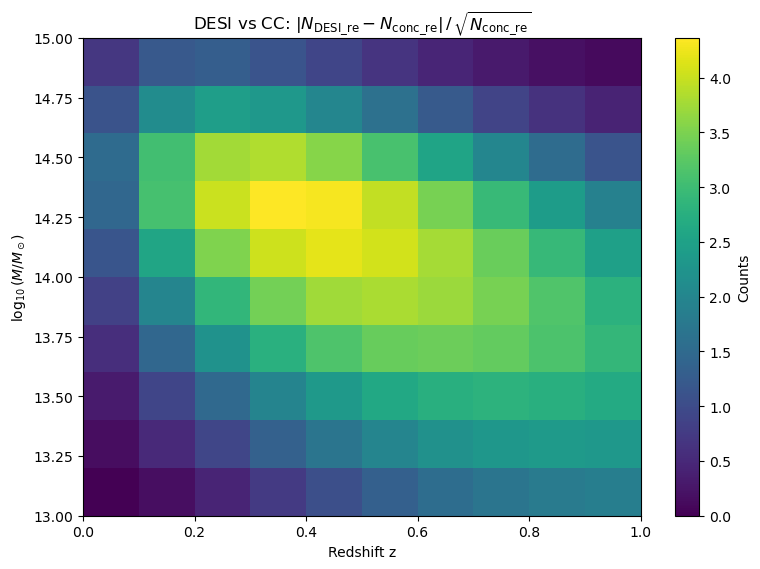

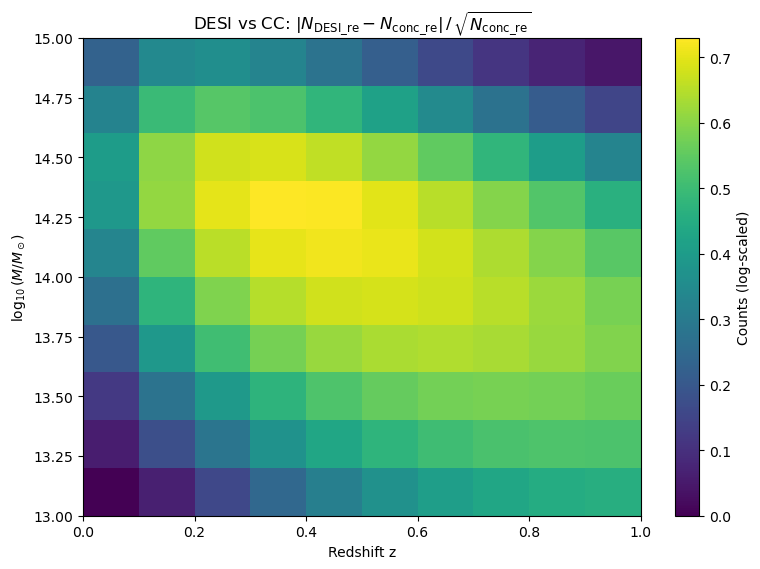

In [101]:
#Plot 9: s:n for gridDESI vs gridCC i.e. grid-DESI - gridCC / sqrt(grid CC)

# Compute signal-to-noise grid
SN_grid = (N_desi - N_conc) / np.sqrt(N_conc)

# Optional: log absolute value for better contrast
SN_log = np.sign(SN_grid) * np.log10(1 + np.abs(SN_grid))

# --- plot SN grid (x=z, y=log10 M)
plt.figure(figsize=(8, 5.8))
pcm = plt.pcolormesh(z_edges, np.log10(M_edges), SN_grid, shading="auto")
plt.xlabel("Redshift z")
plt.ylabel(r"$\log_{10}(M/M_\odot)$")
plt.title(r"DESI vs ΛCDM (CC): ($N_{\rm DESI}-N_{\rm conc})\,/\,\sqrt{N_{\rm conc}}$")
cbar = plt.colorbar(pcm)
#cbar.set_label("σ (Poisson-like)")
plt.tight_layout()
plt.show()

# Compute signal-to-noise grid
SN_grid = np.abs(N_counts_scaled_desi - N_counts_scaled) / np.sqrt(N_counts_scaled)

# Optional: log absolute value for better contrast
SN_log = np.sign(SN_grid) * np.log10(1 + np.abs(SN_grid))

# --- plot SN grid (x=z, y=log10 M)
plt.figure(figsize=(8, 5.8))
pcm = plt.pcolormesh(z_edges, np.log10(M_edges), SN_grid, shading="auto")
plt.xlabel("Redshift z")
plt.ylabel(r"$\log_{10}(M/M_\odot)$")
plt.title(r"DESI vs CC: |$N_{\rm DESI\_re}-N_{\rm conc\_re}|\,/\,\sqrt{N_{\rm conc\_re}}$")
plt.colorbar(pcm, label="Counts")
#cbar.set_label("σ (Poisson-like)")
plt.tight_layout()
plt.show()

# --- plot SN grid (x=z, y=log10 M)
plt.figure(figsize=(8, 5.8))
pcm = plt.pcolormesh(z_edges, np.log10(M_edges), SN_log, shading="auto")
plt.xlabel("Redshift z")
plt.ylabel(r"$\log_{10}(M/M_\odot)$")
plt.title(r"DESI vs CC: |$N_{\rm DESI\_re}-N_{\rm conc\_re}|\,/\,\sqrt{N_{\rm conc\_re}}$")
plt.colorbar(pcm, label="Counts (log-scaled)")
#cbar.set_label("σ (Poisson-like)")
plt.tight_layout()
plt.show()

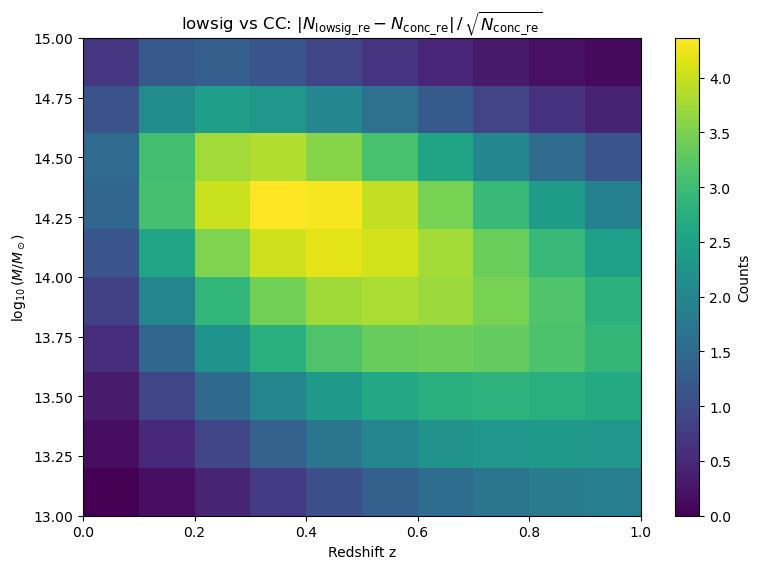

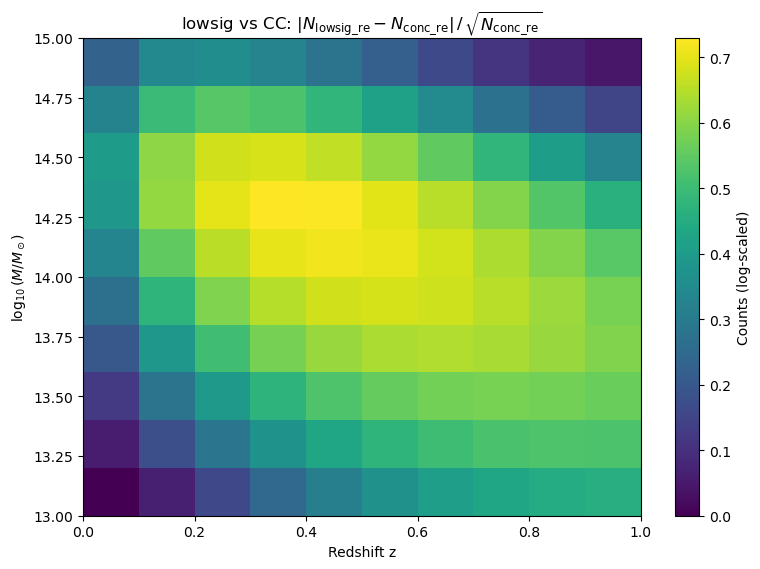

In [102]:
#Plot 10: s:n for grid-lowsig vs gridCC i.e. grid-lowsig - gridCC / sqrt(grid CC)

# Compute signal-to-noise grid
SN_grid = np.abs(N_counts_scaled_low - N_counts_scaled) / np.sqrt(N_counts_scaled)

# Optional: log absolute value for better contrast
SN_log = np.sign(SN_grid) * np.log10(1 + np.abs(SN_grid))

# --- plot SN grid (x=z, y=log10 M)
plt.figure(figsize=(8, 5.8))
pcm = plt.pcolormesh(z_edges, np.log10(M_edges), SN_grid, shading="auto")
plt.xlabel("Redshift z")
plt.ylabel(r"$\log_{10}(M/M_\odot)$")
plt.title(r"lowsig vs CC: |$N_{\rm lowsig\_re}-N_{\rm conc\_re}|\,/\,\sqrt{N_{\rm conc\_re}}$")
plt.colorbar(pcm, label="Counts")
#cbar.set_label("σ (Poisson-like)")
plt.tight_layout()
plt.show()

# --- plot SN grid (x=z, y=log10 M)
plt.figure(figsize=(8, 5.8))
pcm = plt.pcolormesh(z_edges, np.log10(M_edges), SN_log, shading="auto")
plt.xlabel("Redshift z")
plt.ylabel(r"$\log_{10}(M/M_\odot)$")
plt.title(r"lowsig vs CC: |$N_{\rm lowsig\_re}-N_{\rm conc\_re}|\,/\,\sqrt{N_{\rm conc\_re}}$")
plt.colorbar(pcm, label="Counts (log-scaled)")
#cbar.set_label("σ (Poisson-like)")
plt.tight_layout()
plt.show()